In [2]:
# import dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [3]:
# grab our data from the raw github page
url = 'https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv'
df = pd.read_csv(url)

# This is going to be our complete database. Offers a lot more data along with potential for using Machine Learning
df.to_csv('CO2_emissions.csv',index=False)
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001733e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [4]:
# Select the data for the USA, grab the year and CO2, set index to the year(type=int64), drop the name on the axis
df = df[df['iso_code']=='CHN']
df = pd.DataFrame(df[['year','co2']]).dropna()
df = df.set_index(['year'])
df = df.rename_axis(None, axis=1)

In [5]:
# Select the last 100 years of data (training the model on more than that is unecessary)
df = df[len(df)-100:]
df.head()

,co2
year,
1921,25.289
1922,26.634
1923,32.152
1924,35.094
1925,33.221


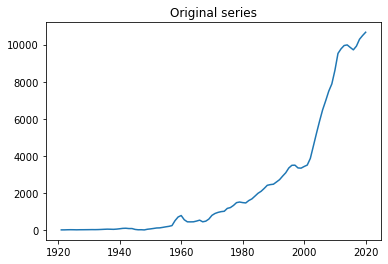

In [6]:
# Original Series
plt.plot(df)
plt.title('Original series');

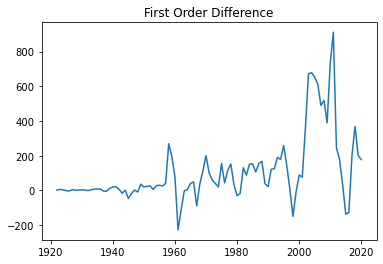

In [7]:
# First order difference
plt.plot(df.diff().dropna())
plt.title('First Order Difference');

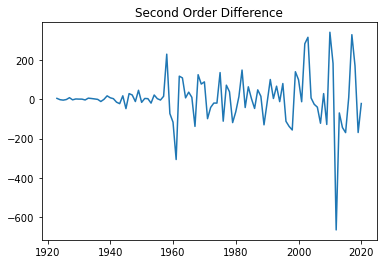

In [8]:
# Second order difference
plt.plot(df.diff().diff().dropna())
plt.title('Second Order Difference');

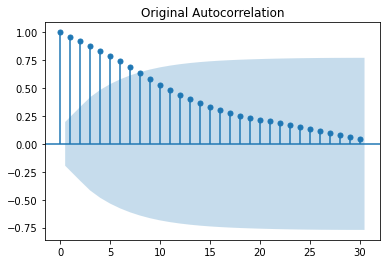

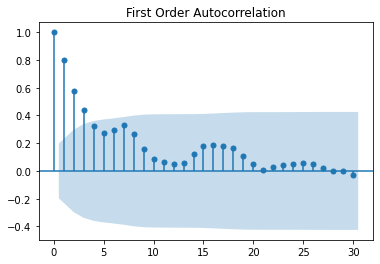

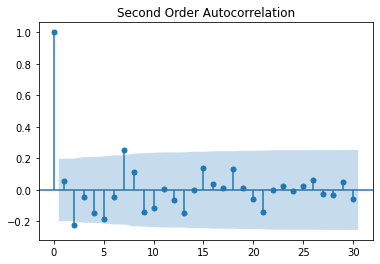

In [9]:
plot_acf(df,lags=30,title='Original Autocorrelation');
plot_acf(df.diff().dropna(),lags=30,title='First Order Autocorrelation');
plot_acf(df.diff().diff().dropna(),lags=30,title='Second Order Autocorrelation');

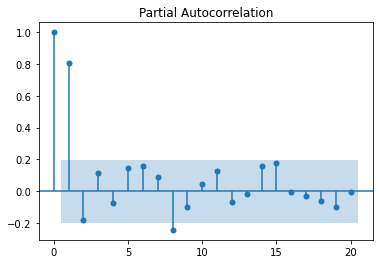

In [10]:
# Used to find q (in this case we will use 1)
plot_pacf(df.diff().dropna(),lags=20);

In [11]:
## This is to gauge what value we should think about using for d in ARIMA(p,d,q) (in this case it is 2)

# first order differencing
result = adfuller(df.dropna())
print('p-value: ', result[1])

# second order differencing
result = adfuller(df.diff().dropna())
print('p-value: ', result[1])

 # third order differencing
result = adfuller(df.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  1.0
p-value:  0.0049992226414836485
p-value:  0.00013504124596919664


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

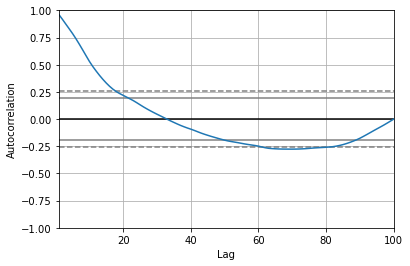

In [12]:
# This is to help us identify the value for p in our model
# Look at the number of lags for the autocorrelation to fall inside our boundary (in this case ~25)
autocorrelation_plot(df)

In [13]:
model = ARIMA(df, order=(18,2,2))
model_fit = model.fit()

print(model_fit.summary())

C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  100
Model:                ARIMA(18, 2, 2)   Log Likelihood                -593.571
Date:                Sun, 01 May 2022   AIC                           1229.143
Time:                        15:20:45   BIC                           1283.427
Sample:                             0   HQIC                          1251.100
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3154      2.962     -0.444      0.657      -7.121       4.490
ar.L2         -0.7914      2.790     -0.284      0.777      -6.260       4.677
ar.L3         -0.5274      1.069     -0.493      0.6

C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


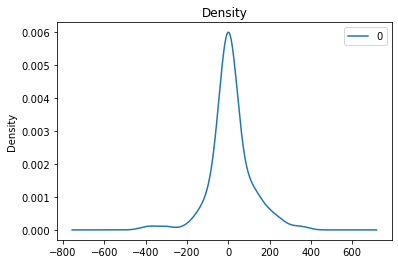

In [14]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde', title='Density')
plt.show()

In [15]:
# show the distribution of our residuals
print(residuals.describe()[0])

count    100.000000
mean      12.977677
std       99.302304
min     -387.185440
25%      -16.243833
50%        1.813968
75%       40.318416
max      349.534853
Name: 0, dtype: float64


In [27]:
# our CO2 emissions
X=df.values

# selecting a testing size (70% train, 30% test)
size = int(len(X)*.7)

# slices our original data into train,test sets
train, test = X[0:size], X[size:len(X)]

# stores our past values, initialized to hold the training set
history = [x for x in train]

# list to hold our model's predictions
predictions = list()

# iterate through our test data
for t in range(len(test)):
    
    # Fit the model to our initialzied data (training set) using (p,d,q) from the analysis above
    model = ARIMA(history, order=(18,2,2))
    
    # Fit the model
    model_fit = model.fit()
    
    # predict the next value based on the fitted model.
    output = model_fit.forecast()
    yhat = output[0]
    
    # add the prediction to our list of predictions
    predictions.append(yhat)
    
    
    obs = test[t]
    history.append(obs)
    
    #print('predicted = %f, expected = %f' %(yhat,obs))

rmse = np.sqrt(mean_squared_error(test, predictions))

C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to 

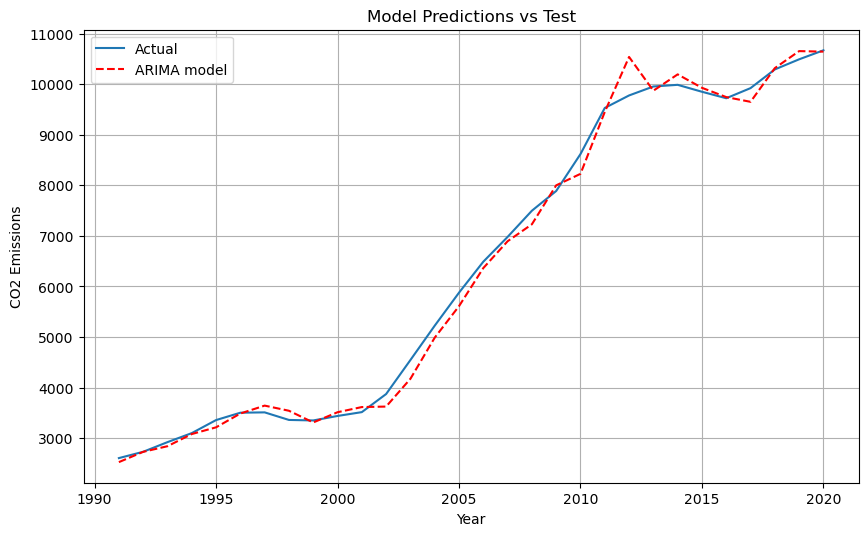

RMSE: 218.451


In [28]:
x = df.index[-len(test):].values
plt.figure(figsize=(10,6),dpi=100)
plt.plot(x, test, label='Actual')
plt.plot(x,predictions, color='r', linestyle='--',label='ARIMA model')
plt.title('Model Predictions vs Test')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid()
plt.show()
print("RMSE: %.3f" % rmse)

In [30]:
history = df.values
predictions = list()
forecast = 20

for t in range(forecast):
    model = ARIMA(history, order=(18,2,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history = np.append(history,yhat)
    

C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nodna\

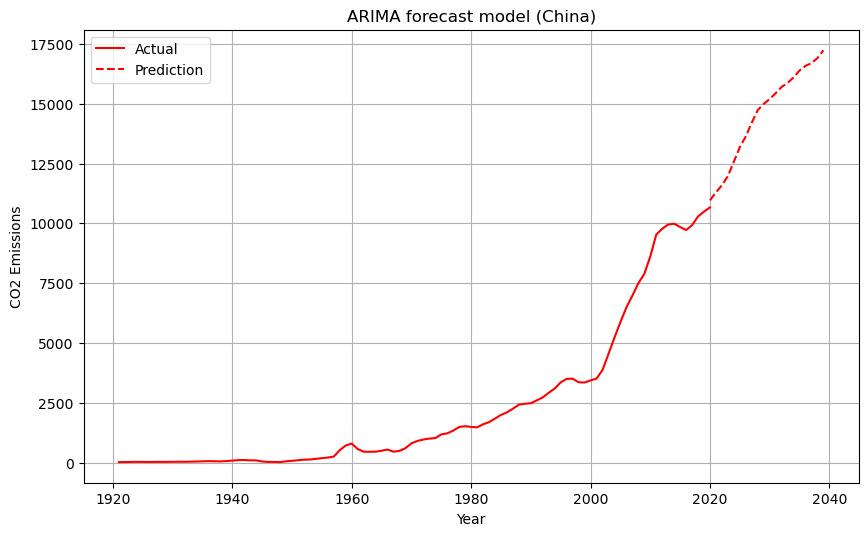

In [49]:
x =  list(range(df.index[-1],df.index[-1]+forecast))
plt.figure(figsize=(10,6),dpi=100)
plt.plot(df.index[:],history[:-forecast], color='red',label='Actual')
plt.plot(x,predictions,color='red', linestyle='--',label='Prediction')
plt.title('ARIMA forecast model (China)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid()
plt.show()